# Linear Regression

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "./data/etf_1698.csv"
test_size = 0.2                 # テストサイズ
cv_size = 0.2                   # バリデーションサイズ

Nmax = 30

fontsize = 14
ticklabelsize = 14
####################################

In [2]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    t日の値を t-1, t-2, ..., t-N日の値に対する線形回帰で求める
    Inputs
        df             :予測に使用するデータ
        target_col :予測する値
        N              :t日の値を t-1, t-2, ..., t-N日の値を用いて予測する
        pred_min   :予測値の最低値
        offset         :len(df)-offsetを用いて予測
    Outputs
        pred_list
    """
    # 線形回帰モデルを作成
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df[target_col])):
        X_train = np.array(range(len(df[target_col][i-N:i])))
        y_train = np.array(df[target_col][i-N:i])
        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train)
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])
    
    #  予測値がpred_minより小さい場合はpred_minを代入
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
   平均絶対パーセント誤差 (MAP Error) を求める
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# データ読み込み

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Dete列をdate型に変換
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# headを小文字に変換
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# month列を追加
df['month'] = df['date'].dt.month

# datetimeでソート
df.sort_values(by='date', inplace=True, ascending=True)


df.head()

,date,open,high,low,close,volume,trading_value,month
0,2015-01-05,1529,1529,1486,1498,9510,1498,1
1,2015-01-06,1451,1465,1451,1452,11550,1452,1
2,2015-01-07,1450,1460,1447,1450,4720,1450,1
3,2015-01-08,1469,1477,1468,1471,1330,1471,1
4,2015-01-09,1480,1481,1468,1472,2050,1472,1


Text(0, 0.5, 'JPY')

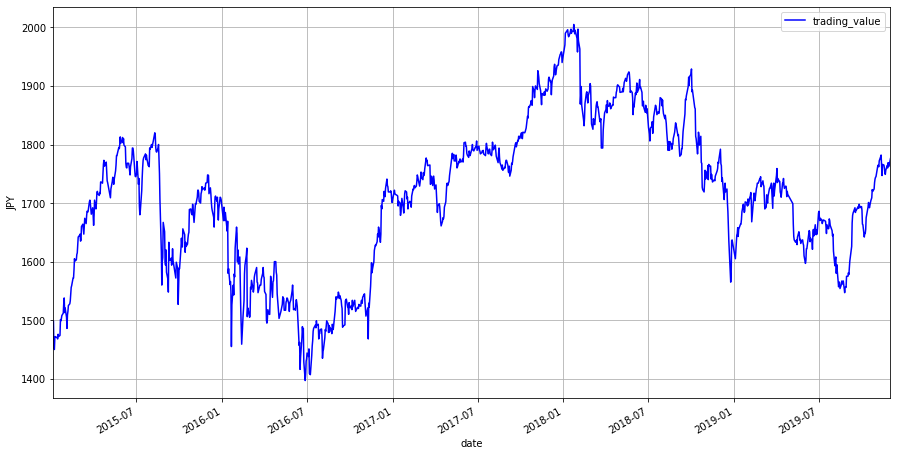

In [4]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = df.plot(x='date', y='trading_value', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# データをtrain,cv,testに分割 

In [5]:
# データセットのサイズ取得
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))


# train, cv, testに分割
train = df[:num_train][['date', 'trading_value']]
cv = df[num_train:num_train+num_cv][['date', 'trading_value']]
train_cv = df[:num_train+num_cv][['date', 'trading_value']]
test = df[num_train+num_cv:][['date', 'trading_value']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 720
num_cv = 239
num_test = 239
train.shape = (720, 2)
cv.shape = (239, 2)
train_cv.shape = (959, 2)
test.shape = (239, 2)


Text(0, 0.5, 'JPY')

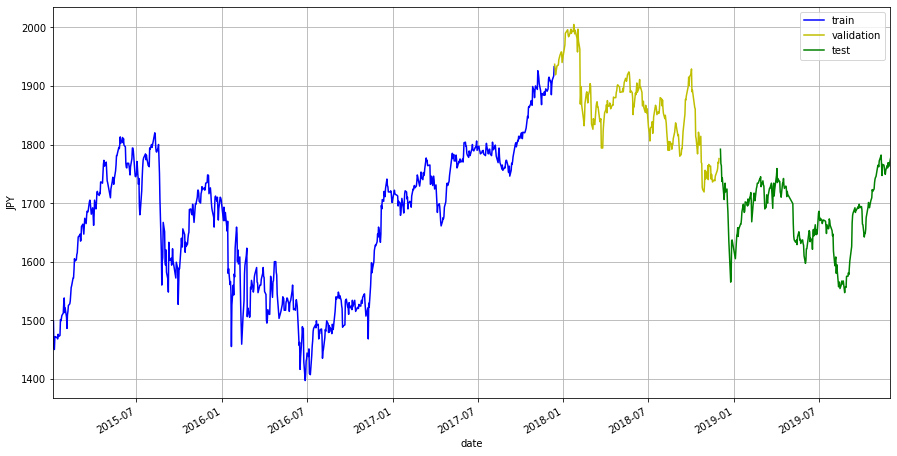

In [6]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

# モデルチューニング：N

In [7]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1):
    est_list = get_preds_lin_reg(train_cv, 'trading_value', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['trading_value'])))
    R2.append(r2_score(cv['trading_value'], est_list))
    mape.append(get_mape(cv['trading_value'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [15.385016892089345, 21.71920462108097, 18.467481818179444, 18.868267177357612, 18.93172383498176, 19.264222166882973, 19.97628600092906, 20.850308926556696, 22.046780212036783, 23.29032817140923, 24.50512381929143, 25.478729786824893, 26.420304594434878, 27.17910626992044, 27.923232481390716, 28.552189607467103, 29.148918490293415, 29.576892241481104, 29.951860748981108, 30.351263707033937, 30.86146416945951, 31.426964974978, 32.01232105763473, 32.63596310490648, 33.26451447760755, 33.95381313077633, 34.64175435480401, 35.33505568829462, 35.95621131926339, 36.509101711616346]
R2 = [0.9447036679107801, 0.8897983229498713, 0.9203261634982605, 0.916830439900436, 0.9162700771481406, 0.913303148436302, 0.9067755426141803, 0.8984393766186511, 0.8864490649102692, 0.8732781262780018, 0.8597140516617301, 0.8483452855237911, 0.8369292719210564, 0.8274278486138726, 0.8178489184987838, 0.8095507758297059, 0.801506969929947, 0.795635504282385, 0.7904208928910731, 0.7847942226758913, 0.77749

,date,trading_value,est_N1,est_N2,est_N3,est_N4,est_N5,est_N6,est_N7,est_N8,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
720,2017-12-13,1937,1933.0,1949.0,1943.000000,1940.5,1942.7,1932.066667,1926.142857,1920.285714,...,1916.128571,1912.935065,1909.683794,1906.673913,1906.76,1906.332308,1906.467236,1907.476190,1907.522167,1906.990805
721,2017-12-14,1930,1937.0,1941.0,1949.000000,1948.5,1947.7,1950.000000,1941.428571,1935.892857,...,1924.214286,1921.571429,1918.351779,1915.061594,1911.99,1911.886154,1911.301994,1911.269841,1912.093596,1912.002299
722,2017-12-15,1919,1930.0,1923.0,1930.333333,1940.0,1943.4,1945.200000,1948.857143,1942.785714,...,1929.180952,1927.506494,1924.932806,1921.786232,1918.55,1915.504615,1915.301994,1914.642857,1914.519704,1915.229885
723,2017-12-18,1934,1919.0,1908.0,1910.666667,1917.5,1927.5,1933.133333,1937.000000,1942.071429,...,1928.880952,1929.857143,1928.335968,1925.931159,1922.95,1919.855385,1916.920228,1916.706349,1916.051724,1915.912644
724,2017-12-19,1935,1934.0,1949.0,1931.666667,1925.0,1925.8,1931.933333,1936.142857,1939.464286,...,1932.790476,1932.090909,1932.984190,1931.496377,1929.15,1926.233846,1923.190883,1920.285714,1919.995074,1919.282759


(2, 30)

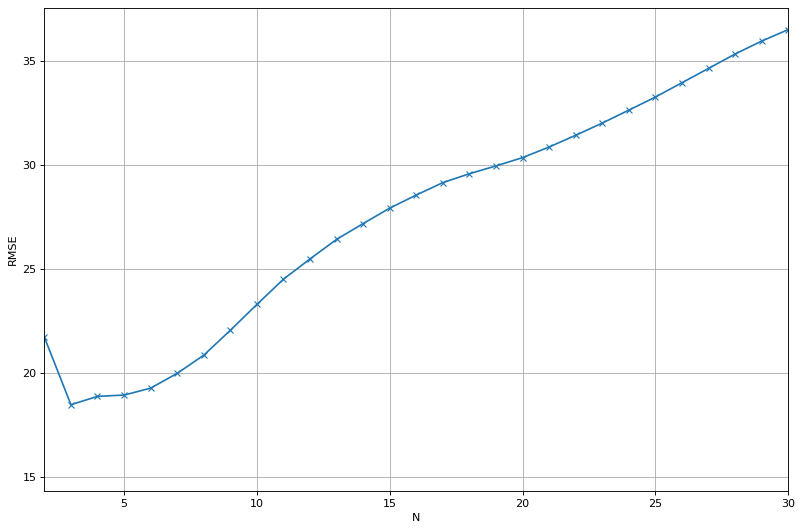

In [8]:
# RMSEをプロット
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Text(0, 0.5, 'R2')

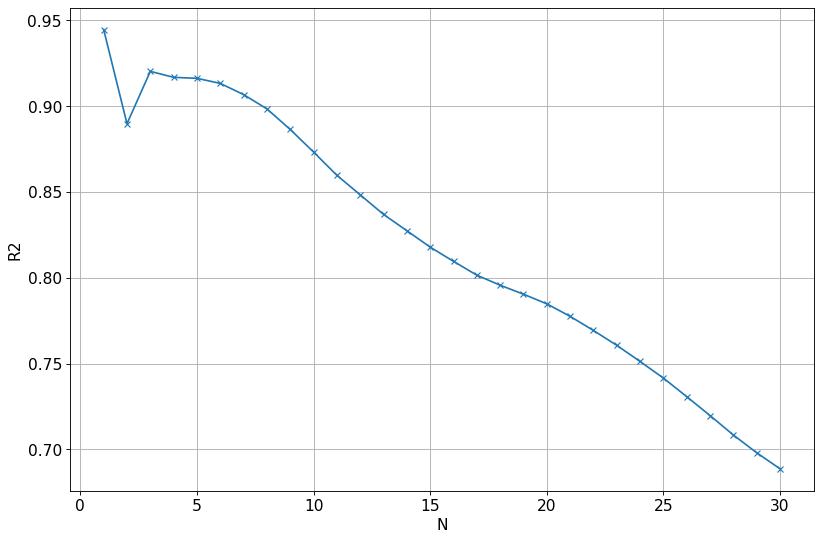

In [9]:
# R2をプロット
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

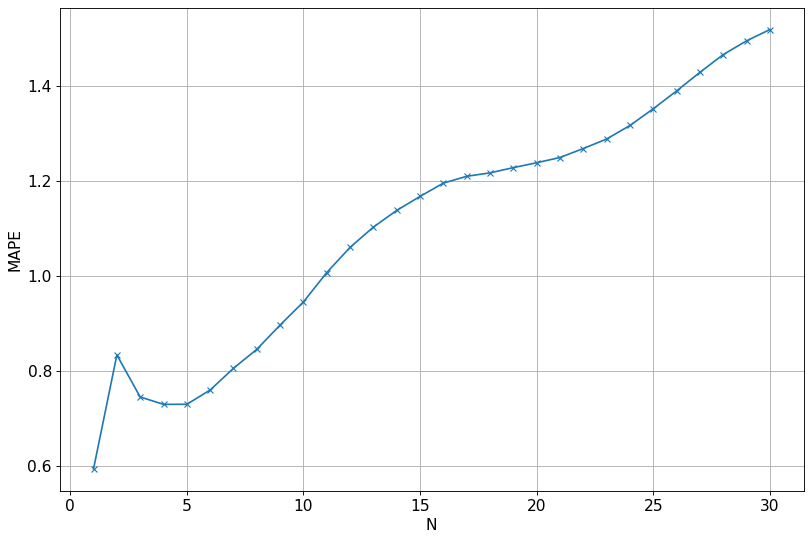

In [10]:
# MAPEをプロット
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [11]:
# 最適なNを決定
N_opt = 3

Text(0, 0.5, 'JPY')

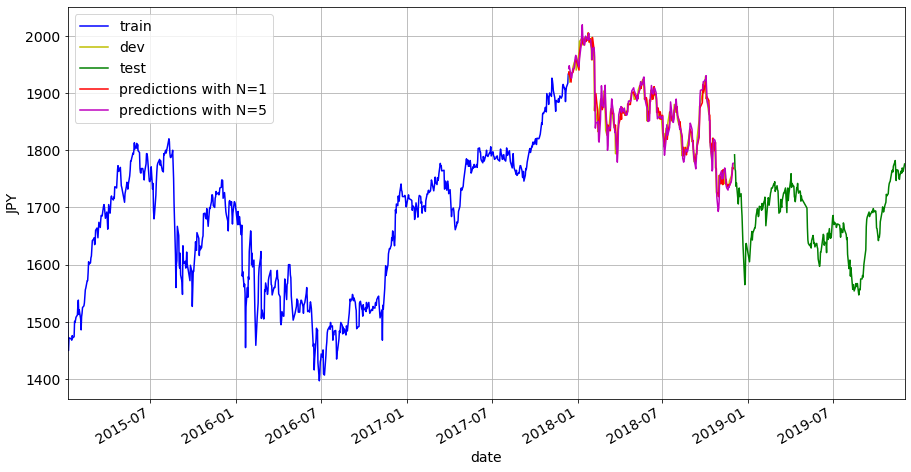

In [12]:
#trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

(1750, 1900)

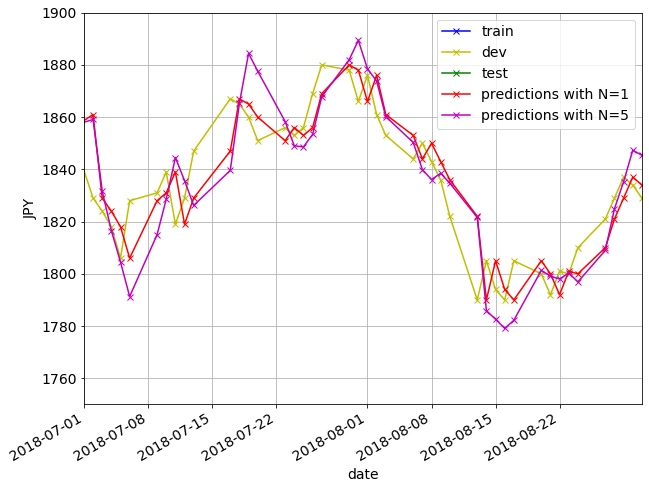

In [13]:
# trading_value(dev)をプロット
rcParams['figure.figsize'] = 10, 8

ax = train.plot(x='date', y='trading_value', style='bx-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2018, 7, 1), date(2018, 8, 31)])
ax.set_ylim([1750, 1900])

# 結果

In [14]:
est_list = get_preds_lin_reg(df, 'trading_value', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['trading_value'])))
print("R2 = %0.3f" % r2_score(test['trading_value'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['trading_value'], est_list))
test.head()

RMSE = 18.882
R2 = 0.887
MAPE = 0.837%


,date,trading_value,est_N3
959,2018-12-03,1792,1777.333333
960,2018-12-04,1767,1802.666667
961,2018-12-05,1764,1769.333333
962,2018-12-06,1737,1746.333333
963,2018-12-07,1743,1726.000000


Text(0, 0.5, 'JPY')

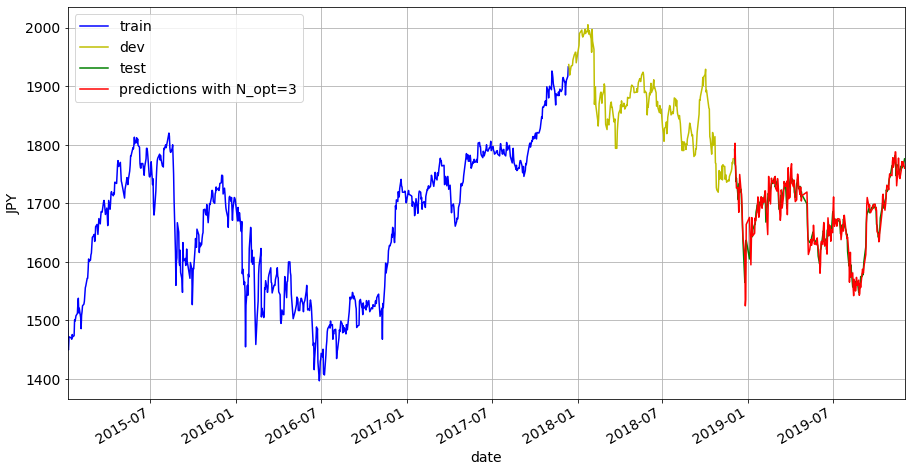

In [15]:
# trading_valueをプロット
rcParams['figure.figsize'] = 15, 8

ax = train.plot(x='date', y='trading_value', style='b-', grid=True)
ax = cv.plot(x='date', y='trading_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='trading_value', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("JPY")

(737038.0, 737395.0)

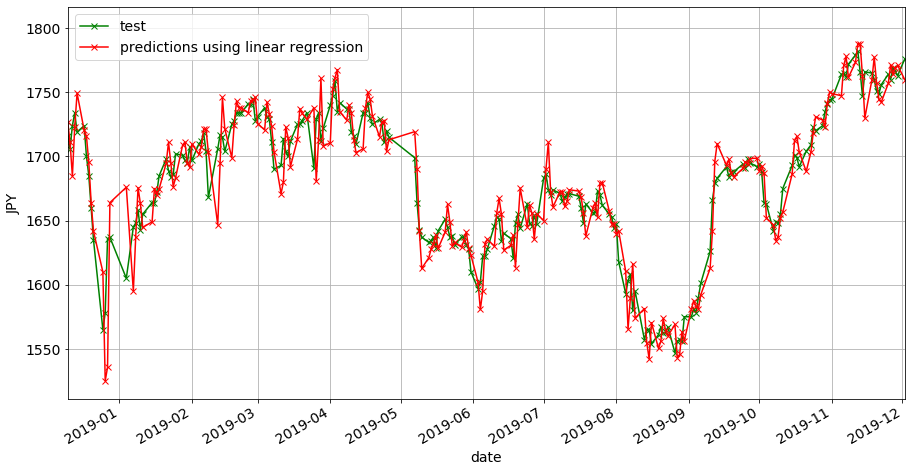

In [16]:
# trading_value(test)をプロット
rcParams['figure.figsize'] = 15, 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='trading_value', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N3', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("JPY")
ax.set_xlim([date(2018, 12, 10), date(2019, 12, 2)])

In [17]:
# 結果を保存
test_lin_reg = test
test_lin_reg.to_csv("./out/test_lin_reg.csv")